In [1]:
import os
import joblib
from tqdm import tqdm
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## LSTM

### Data Importing

In [3]:
df = pd.read_csv("./.data/train_aug.csv")

In [4]:
print(df)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.094944  3.205389  3.313624  3.339701  3.361018  3.379836   
1           p01_1  3.340175  3.361399  3.380423  3.339701  3.294160  3.246258   
2           p01_2  3.340175  3.294538  3.246826  3.172513  3.093589  3.012496   
3           p01_3  3.172972  3.093953  3.013033  3.038763  3.060160  3.079285   
4           p01_4  3.039210  3.060522  3.079831  3.061055  3.037874  3.012496   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.156654 -0.156741 -0.210417 -0.177942 -0.285088 -0.383573   
354044  p12_25295 -0.153169 -0.205252 -0.177643 -0.291374 -0.403435 -0.453188   
354045  p12_25296 -0.182927 -0.187252 -0.292545 -0.392158 -0.450797 -0.517543   
354046  p12_25297 -0.197369 -0.276990 -0.399657 -0.454536 -0.553658 -0.620565   
354047  p12_25298 -0.285812 -0.385110 -0.459777 -0.539657 -0.641673 -0.682555   

         bg-1:25   bg-1:20 

In [5]:
for col in df.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

### Data Splitting

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (283238, 146)
Validation Shape: (35405, 146)
Test Shape: (35405, 146)


### Dataset and DataLoader

In [8]:
class BrisT1DDataset(Dataset):
    def __init__(self, df, is_train=True):
        
        self.df = df
        self.is_train = is_train
        
        if 'id' in self.df.columns:
            self.ids = self.df['id'].values
            self.df = self.df.drop(columns=['id'])
        else:
            self.ids = None
        
        
        if self.is_train and 'bg+1:00' in self.df.columns:
            self.targets = self.df['bg+1:00'].values
            self.df = self.df.drop(columns=['bg+1:00'])
        else:
            self.targets = None
        
        
        data = self.df.values.astype(np.float32)
        if data.shape[1] != 144:
            raise ValueError(f"Expected 144, Real  {data.shape[1]}")

        self.X = data.reshape(-1, 6, 24).transpose(0, 2, 1)
        
        if self.is_train:
            self.y = self.targets.astype(np.float32).reshape(-1, 1)
        else:
            self.y = None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.is_train:
            target = torch.tensor(self.y[idx], dtype=torch.float32)
            return sample, target
        else:
            return sample

In [9]:
train_dataset = BrisT1DDataset(train_df, is_train=True)
val_dataset = BrisT1DDataset(val_df, is_train=True)
test_dataset = BrisT1DDataset(test_df, is_train=True)

In [10]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [11]:
class BrisT1DLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [12]:
model = BrisT1DLSTM(input_size=6, hidden_size=64, num_layers=2, dropout=0.25).to(device)
print(model)

BrisT1DLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.25)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


#### Model Summary

In [13]:
dummy_seq = torch.randn(1, 24, 6).to(device)

In [14]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
BrisT1DLSTM                              [1, 1]                    --
├─LSTM: 1-1                              [1, 24, 64]               51,712
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
Total mult-adds (M): 1.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.22
Estimated Total Size (MB): 0.23


#### Model Computational Graph

In [15]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


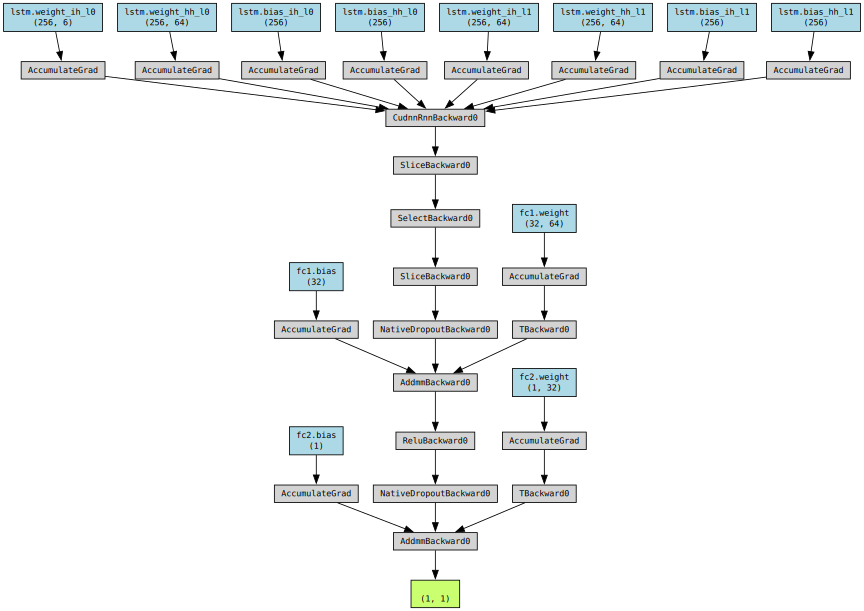

In [16]:
print("Model Computational Graph:")
display(dot)

### Training

In [17]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
patience = 10

In [18]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

In [19]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            running_val_loss += loss.item() * X_val.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), './.export/checkpoint-aug-lstm.pt')
    else:
        epochs_no_improve += 1
        print(f"Early Stopping: {epochs_no_improve}/{patience}")
        
    if epochs_no_improve >= patience:
        print("Early Stopping!")
        break

Epoch 1/100 [Training]:   0%|          | 0/1107 [00:00<?, ?it/s]

Epoch: 1/100 | Train Loss: 0.5059 | Val Loss: 0.4471


Epoch: 2/100 | Train Loss: 0.4635 | Val Loss: 0.4356


Epoch: 3/100 | Train Loss: 0.4513 | Val Loss: 0.4341


Epoch: 4/100 | Train Loss: 0.4417 | Val Loss: 0.4140


Epoch: 5/100 | Train Loss: 0.4334 | Val Loss: 0.4081


Epoch: 6/100 | Train Loss: 0.4261 | Val Loss: 0.4026


Epoch: 7/100 | Train Loss: 0.4175 | Val Loss: 0.3955


Epoch: 8/100 | Train Loss: 0.4089 | Val Loss: 0.3864


Epoch: 9/100 | Train Loss: 0.4000 | Val Loss: 0.3802


Epoch: 10/100 | Train Loss: 0.3928 | Val Loss: 0.3666


Epoch: 11/100 | Train Loss: 0.3833 | Val Loss: 0.3605


Epoch: 12/100 | Train Loss: 0.3737 | Val Loss: 0.3509


Epoch: 13/100 | Train Loss: 0.3644 | Val Loss: 0.3442


Epoch: 14/100 | Train Loss: 0.3554 | Val Loss: 0.3303


Epoch: 15/100 | Train Loss: 0.3463 | Val Loss: 0.3265


Epoch: 16/100 | Train Loss: 0.3382 | Val Loss: 0.3137


Epoch: 17/100 | Train Loss: 0.3290 | Val Loss: 0.3042


Epoch: 18/100 | Train Loss: 0.3209 | Val Loss: 0.2994


Epoch: 19/100 | Train Loss: 0.3133 | Val Loss: 0.2941


Epoch: 20/100 | Train Loss: 0.3063 | Val Loss: 0.2808


Epoch: 21/100 | Train Loss: 0.2986 | Val Loss: 0.2786


Epoch: 22/100 | Train Loss: 0.2919 | Val Loss: 0.2689


Epoch: 23/100 | Train Loss: 0.2860 | Val Loss: 0.2651


Epoch: 24/100 | Train Loss: 0.2794 | Val Loss: 0.2575


Epoch: 25/100 | Train Loss: 0.2740 | Val Loss: 0.2525


Epoch: 26/100 | Train Loss: 0.2688 | Val Loss: 0.2439


Epoch: 27/100 | Train Loss: 0.2631 | Val Loss: 0.2403


Epoch: 28/100 | Train Loss: 0.2587 | Val Loss: 0.2330


Epoch: 29/100 | Train Loss: 0.2537 | Val Loss: 0.2299


Epoch: 30/100 | Train Loss: 0.2504 | Val Loss: 0.2284


Epoch: 31/100 | Train Loss: 0.2469 | Val Loss: 0.2211


Epoch: 32/100 | Train Loss: 0.2422 | Val Loss: 0.2153


Epoch: 33/100 | Train Loss: 0.2398 | Val Loss: 0.2113


Epoch: 34/100 | Train Loss: 0.2348 | Val Loss: 0.2097


Epoch: 35/100 | Train Loss: 0.2324 | Val Loss: 0.2060


Epoch: 36/100 | Train Loss: 0.2291 | Val Loss: 0.2022


Epoch: 37/100 | Train Loss: 0.2275 | Val Loss: 0.1995


Epoch: 38/100 | Train Loss: 0.2225 | Val Loss: 0.1988


Epoch: 39/100 | Train Loss: 0.2203 | Val Loss: 0.1959


Epoch: 40/100 | Train Loss: 0.2185 | Val Loss: 0.1927


Epoch: 41/100 | Train Loss: 0.2160 | Val Loss: 0.1912


Epoch: 42/100 | Train Loss: 0.2138 | Val Loss: 0.1859


Epoch: 43/100 | Train Loss: 0.2126 | Val Loss: 0.1859


Epoch: 44/100 | Train Loss: 0.2093 | Val Loss: 0.1813


Epoch: 45/100 | Train Loss: 0.2071 | Val Loss: 0.1859
Early Stopping: 1/10


Epoch: 46/100 | Train Loss: 0.2048 | Val Loss: 0.1765


Epoch: 47/100 | Train Loss: 0.2037 | Val Loss: 0.1771
Early Stopping: 1/10


Epoch: 48/100 | Train Loss: 0.2025 | Val Loss: 0.1742


Epoch: 49/100 | Train Loss: 0.2000 | Val Loss: 0.1782
Early Stopping: 1/10


Epoch: 50/100 | Train Loss: 0.1979 | Val Loss: 0.1717


Epoch: 51/100 | Train Loss: 0.1966 | Val Loss: 0.1694


Epoch: 52/100 | Train Loss: 0.1952 | Val Loss: 0.1699
Early Stopping: 1/10


Epoch: 53/100 | Train Loss: 0.1943 | Val Loss: 0.1665


Epoch: 54/100 | Train Loss: 0.1929 | Val Loss: 0.1670
Early Stopping: 1/10


Epoch: 55/100 | Train Loss: 0.1903 | Val Loss: 0.1625


Epoch: 56/100 | Train Loss: 0.1892 | Val Loss: 0.1622


Epoch: 57/100 | Train Loss: 0.1882 | Val Loss: 0.1600


Epoch: 58/100 | Train Loss: 0.1875 | Val Loss: 0.1620
Early Stopping: 1/10


Epoch: 59/100 | Train Loss: 0.1857 | Val Loss: 0.1594


Epoch: 60/100 | Train Loss: 0.1846 | Val Loss: 0.1576


Epoch: 61/100 | Train Loss: 0.1846 | Val Loss: 0.1563


Epoch: 62/100 | Train Loss: 0.1831 | Val Loss: 0.1534


Epoch: 63/100 | Train Loss: 0.1817 | Val Loss: 0.1518


Epoch: 64/100 | Train Loss: 0.1798 | Val Loss: 0.1584
Early Stopping: 1/10


Epoch: 65/100 | Train Loss: 0.1793 | Val Loss: 0.1534
Early Stopping: 2/10


Epoch: 66/100 | Train Loss: 0.1788 | Val Loss: 0.1484


Epoch: 67/100 | Train Loss: 0.1776 | Val Loss: 0.1484


Epoch: 68/100 | Train Loss: 0.1760 | Val Loss: 0.1499
Early Stopping: 1/10


Epoch: 69/100 | Train Loss: 0.1759 | Val Loss: 0.1510
Early Stopping: 2/10


Epoch: 70/100 | Train Loss: 0.1754 | Val Loss: 0.1444


Epoch: 71/100 | Train Loss: 0.1740 | Val Loss: 0.1436


Epoch: 72/100 | Train Loss: 0.1741 | Val Loss: 0.1461
Early Stopping: 1/10


Epoch: 73/100 | Train Loss: 0.1723 | Val Loss: 0.1487
Early Stopping: 2/10


Epoch: 74/100 | Train Loss: 0.1718 | Val Loss: 0.1413


Epoch: 75/100 | Train Loss: 0.1709 | Val Loss: 0.1419
Early Stopping: 1/10


Epoch: 76/100 | Train Loss: 0.1712 | Val Loss: 0.1384


Epoch: 77/100 | Train Loss: 0.1704 | Val Loss: 0.1465
Early Stopping: 1/10


Epoch: 78/100 | Train Loss: 0.1681 | Val Loss: 0.1415
Early Stopping: 2/10


Epoch: 79/100 | Train Loss: 0.1680 | Val Loss: 0.1431
Early Stopping: 3/10


Epoch: 80/100 | Train Loss: 0.1683 | Val Loss: 0.1400
Early Stopping: 4/10


Epoch: 81/100 | Train Loss: 0.1662 | Val Loss: 0.1366


Epoch: 82/100 | Train Loss: 0.1657 | Val Loss: 0.1356


Epoch: 83/100 | Train Loss: 0.1667 | Val Loss: 0.1393
Early Stopping: 1/10


Epoch: 84/100 | Train Loss: 0.1647 | Val Loss: 0.1351


Epoch: 85/100 | Train Loss: 0.1647 | Val Loss: 0.1393
Early Stopping: 1/10


Epoch: 86/100 | Train Loss: 0.1634 | Val Loss: 0.1340


Epoch: 87/100 | Train Loss: 0.1633 | Val Loss: 0.1362
Early Stopping: 1/10


Epoch: 88/100 | Train Loss: 0.1624 | Val Loss: 0.1351
Early Stopping: 2/10


Epoch: 89/100 | Train Loss: 0.1628 | Val Loss: 0.1395
Early Stopping: 3/10


Epoch: 90/100 | Train Loss: 0.1616 | Val Loss: 0.1315


Epoch: 91/100 | Train Loss: 0.1608 | Val Loss: 0.1337
Early Stopping: 1/10


Epoch: 92/100 | Train Loss: 0.1604 | Val Loss: 0.1358
Early Stopping: 2/10


Epoch: 93/100 | Train Loss: 0.1592 | Val Loss: 0.1305


Epoch: 94/100 | Train Loss: 0.1595 | Val Loss: 0.1320
Early Stopping: 1/10


Epoch: 95/100 | Train Loss: 0.1598 | Val Loss: 0.1304


Epoch: 96/100 | Train Loss: 0.1591 | Val Loss: 0.1309
Early Stopping: 1/10


Epoch: 97/100 | Train Loss: 0.1586 | Val Loss: 0.1328
Early Stopping: 2/10


Epoch: 98/100 | Train Loss: 0.1583 | Val Loss: 0.1288


Epoch: 99/100 | Train Loss: 0.1571 | Val Loss: 0.1311
Early Stopping: 1/10


Epoch: 100/100 | Train Loss: 0.1571 | Val Loss: 0.1275


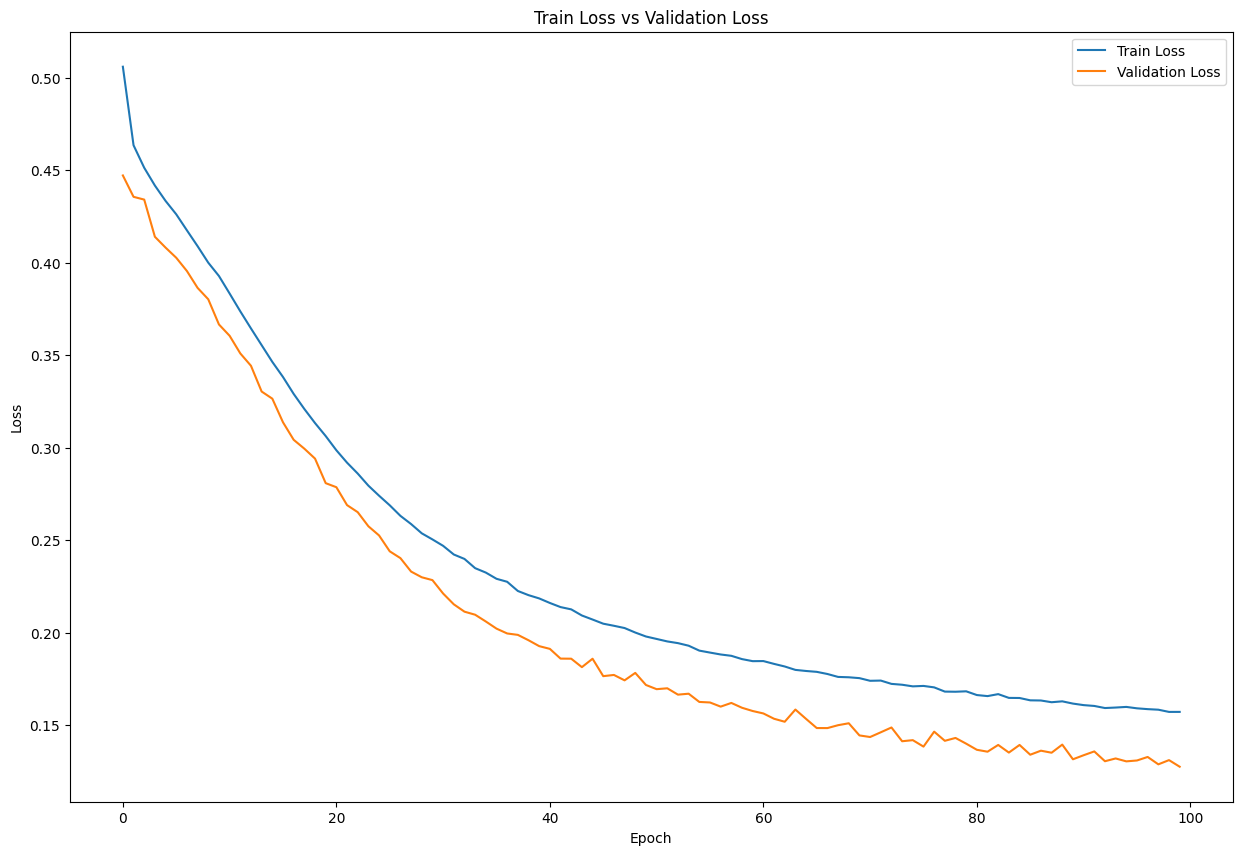

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [21]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-lstm.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33960\3260620653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-ls

<All keys matched successfully>

In [22]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [23]:
model.eval()
preds = []
preds_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        preds.append(outputs.cpu().numpy())
        preds_targets.append(targets.cpu().numpy())
        
preds = np.concatenate(preds)
preds_targets = np.concatenate(preds_targets)

Evaluation: 100%|██████████| 139/139 [00:00<00:00, 195.17it/s]


In [24]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
all_targets = target_scaler.inverse_transform(preds_targets.reshape(-1, 1)).flatten()

In [25]:
# calibration_model = LinearRegression()
# calibration_model.fit(all_preds.reshape(-1, 1), all_targets)
# calibrated_val_preds = calibration_model.predict(all_preds.reshape(-1, 1))

# all_preds = calibrated_val_preds

In [26]:
residuals = all_preds - all_targets

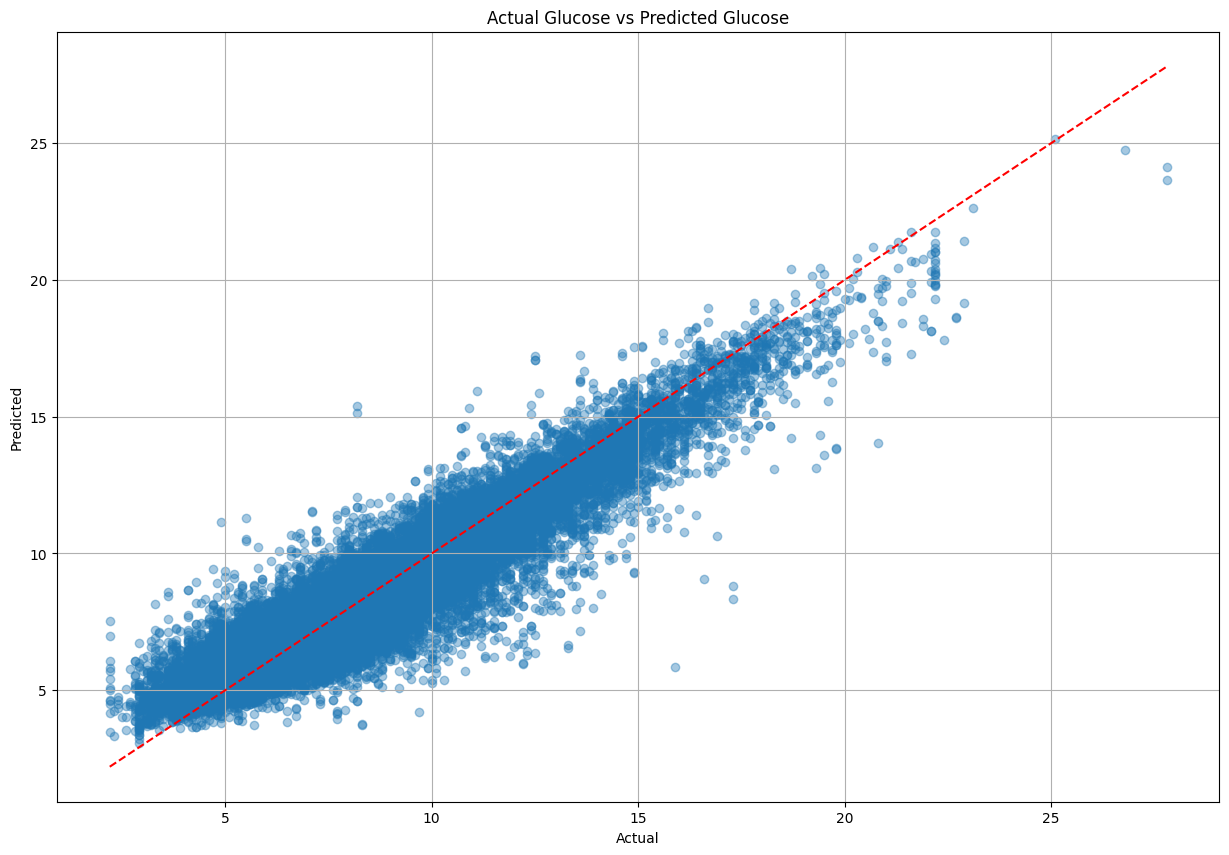

In [27]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

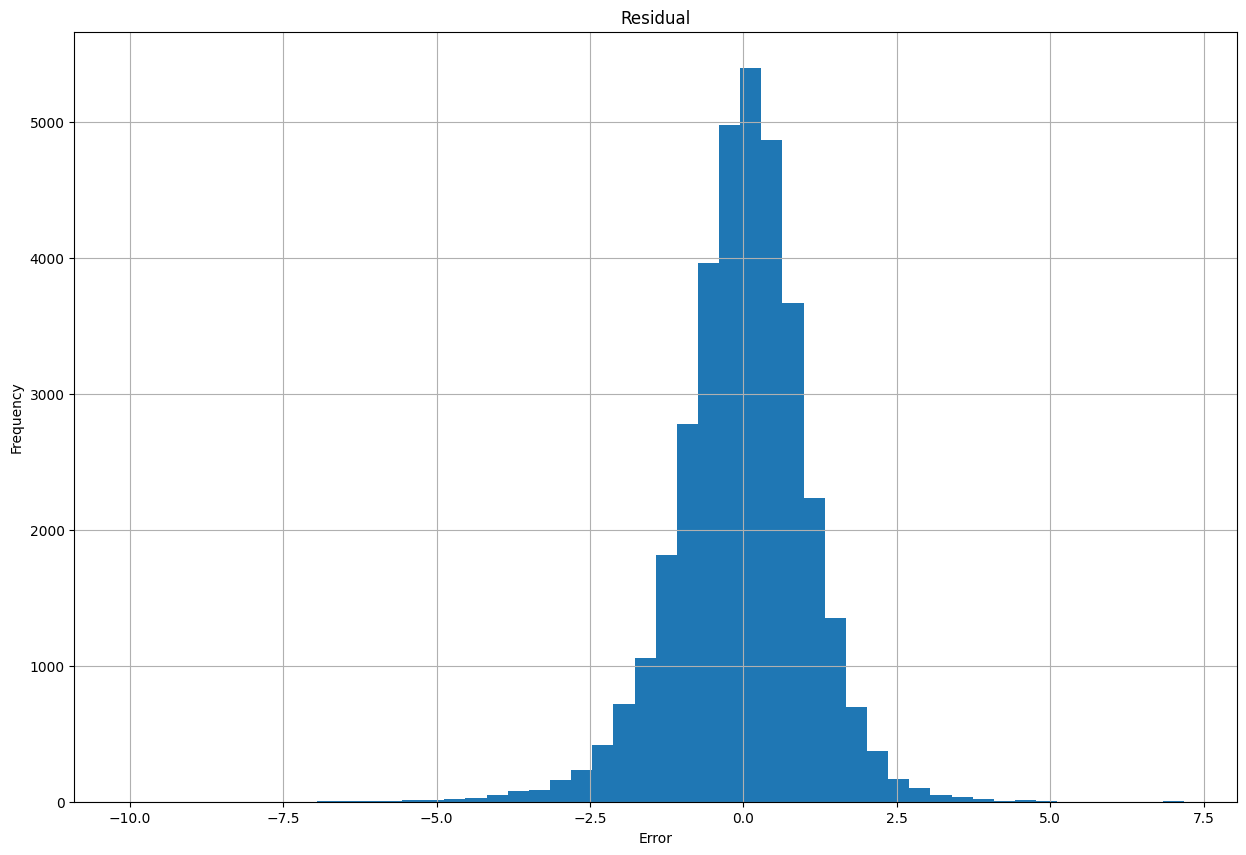

In [28]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [29]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [30]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [31]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [32]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MSE: {test_rmse**2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.0638
Test MSE: 1.1316
Test MAE: 0.7941
Test MARD: 0.1074
Test MBE: -0.0225
Test R²: 0.8725
Test Explained Variance: 0.8726
Test MAPE: 10.74%
Test CCC: 0.9291


### Inference

In [33]:
df_test = pd.read_csv("./.data/test_aug.csv")

In [34]:
print(df_test)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

In [35]:
for col in df_test.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

In [36]:
meta_data = ['id']
df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [37]:
infer_test_dataset = BrisT1DDataset(df_test, is_train=False)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=256, shuffle=False)

In [38]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-lstm.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33960\3260620653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-ls

<All keys matched successfully>

In [39]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)

Inference: 100%|██████████| 15/15 [00:00<00:00, 246.55it/s]


In [40]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds_original = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

In [41]:
# calibrated_test_preds = calibration_model.predict(all_preds_original.reshape(-1, 1))
# all_preds_original = calibrated_test_preds

In [42]:
df_predictions = pd.DataFrame(all_preds_original, columns=["bg+1:00"])
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_aug_lstm.csv", index=False)

### Submission

In [43]:
!kaggle competitions submit -c brist1d -f ./.export/test_submission_aug_lstm.csv -m "BrisT1D Submission: LSTM"


  0%|          | 0.00/68.0k [00:00<?, ?B/s]
100%|██████████| 68.0k/68.0k [00:00<00:00, 79.3kB/s]


Successfully submitted to BrisT1D Blood Glucose Prediction Competition


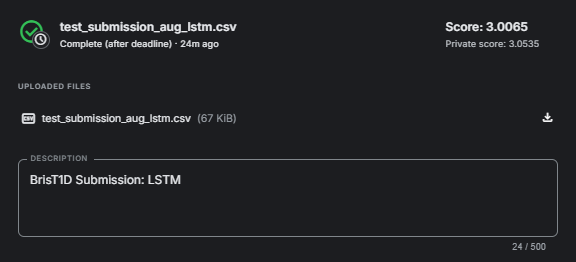

In [44]:
display(Image(filename='./.export/test_submission_aug_lstm.png'))